In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import xgboost as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=0

In [3]:
print FOLD

0


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz",with_l2=True)
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

0

# cv

In [9]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [10]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 
                'visitor_ma7', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 
                'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 
                'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'geo2_visitors_mean', 
                'station_visitors_mean', 'geo2_count_y1', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 
                'station_count_y3', 'station_count_y4',
               's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio',
               'bad_ratio'])
len(lag_cols)

32

In [27]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [11]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean',
                    '3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl'                                                            
                   ])

In [12]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [13]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [14]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [15]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [16]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,max_depth=4,subsample=1,C=0.1,
                                    learning_rate=0.02,min_child_weight=1,objective='reg:l1f0',
                                     gamma=0,reg_alpha=0,reg_lambda=1 ):
        models=[]
        scores=[]
        d_train = lgb.DMatrix(trainX, label=trainy)
        d_valid = lgb.DMatrix(validX, label=validy)
        
        if 1:
            params = {}
            params['eta'] = learning_rate
            params['objective'] = objective
            params['eval_metric'] = 'rmse'
            params['max_depth'] = max_depth
            params['colsample_bytree'] = colsample_bytree
            params['subsample'] = subsample
            params['min_child_weight'] = min_child_weight 
            params['gamma'] = gamma            
            params['reg_alpha'] = reg_alpha            
            params['reg_lambda'] = reg_lambda            
            params['silent'] = 1
            params['nthread'] = 8
            params['tree_method']='hist'
            print i, params
            watchlist = [(d_train, 'train'), (d_valid, 'valid')]
            
            gbm = lgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=50, verbose_eval=50)


            models.append(gbm)
            validpred=gbm.predict(d_valid,ntree_limit=gbm.best_ntree_limit)
            scores.append(mean_squared_error(validy,validpred))
            print mean_squared_error(trainy,gbm.predict(d_train,ntree_limit=gbm.best_ntree_limit)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [17]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [18]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    d_test = lgb.DMatrix(testX, label=testy)    
    test_pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        d_test = lgb.DMatrix(X)    
        pred=model.predict(d_test,ntree_limit=model.best_ntree_limit).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    d_test = lgb.DMatrix(X)    
    pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)

    return pred,dataidx


In [19]:
parameter={'colsample_bytree': 0.5,
 'learning_rate': 0.02,
 'max_depth': 8,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'subsample': 1}

In [20]:
EXCLUDE_HARD=False
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [21]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [22]:
def ff(offset):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    #validpreds[offset]=[validpred,pred478]
    return offset, [validpred,pred478]
    #pickle.dump(validpreds, open('3005_rf_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [23]:
j=FOLD
validpreds={}

In [28]:
p = Pool(1,maxtasksperchild=1)



1
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 14.804288
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)
(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(5803, 1, 28) (5803, 7, 32) (5803, 1) (5803, 1)
(5803, 252) (5803,) (5803,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.3954	valid-rmse:2.3879
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.986426	valid-rmse:0.986899
[100]	train-rmse:0.577037	valid-rmse:0.586388
[150]	train-rmse:0.492586	valid-rmse:0.509477
[200]	train-rmse:0.476046	valid-rmse:0.498117
[250]	train-rmse:0.470296	valid-rmse:0.496495
[300]	train-rmse:0.466525	valid-rmse:0.496196
[350]	train-rmse:0.463199	valid-rmse:0.496093
[400]	train-rmse:0.459669	valid-rmse:0.496113
Stopping. Best iteration:
[350]	train-rmse:0.463199	valid-rmse:0.496093

0.2145529 0.24610823
[0.24610823]
-1 mean score 0.24610823
0.190539196134


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912601  0.016509  0.199527    7  2017-04-16
472     2.507290  2.539667 -0.032377  0.204438    1  2017-04-17
473     2.661330  2.653563  0.007767  0.220853    2  2017-04-18
474     2.754815  2.742560  0.012255  0.186858    3  2017-04-19
475     2.713762  2.709599  0.004163  0.212695    4  2017-04-20
476     2.999000  2.989983  0.009016  0.144751    5  2017-04-21
477     3.075529  3.087715 -0.012186  0.164651    6  2017-04-22

0.190539196134


pred         y     error    error2  day        date
dayidx                                                         
471     2.912601  2.929110  0.016509  0.199527    7  2017-04-16
472     2.539667  2.507290 -0.032377  0.204438    1  2017-04-17
473     2.653563  2.661330  0.007767  0.220853    2  2017-04-18
474     2.742560  2.754815  0.012255  0.186858    3  2017-04-19
475     2.709599  2.713762  0.004163  0.212695    4  2017-04-20
476     2.989983  2.999000  0.009016  0.144751    5  2017-04-21
477     3.087715  3.075529 -0.012186  0.164651    6  2017-04-22

(829, 252)


In [29]:
results=p.map(ff, range(1,40),chunksize=1)



2
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 14.804288
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 6632 records out of 6632 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(6632, 1, 28) (6632, 7, 32) (6632, 1) (6632, 1)
(6632, 252) (6632,) (6632,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.41815	valid-rmse:2.41149
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.991247	valid-rmse:0.992352
[100]	train-rmse:0.573408	valid-rmse:0.58369
[150]	train-rmse:0.486453	valid-rmse:0.50441
[200]	train-rmse:0.469279	valid-rmse:0.492664
[250]	train-rmse:0.463483	valid-rmse:0.491044
[300]	train-rmse:0.459483	valid-rmse:0.490784
[350]	train-rmse:0.455918	valid-rmse:0.490679
[400]	train-rmse:0.452643	valid-rmse:0.490739
Stopping. Best iteration:
[360]	train-rmse:0.45

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.880020  0.049090  0.254994    7  2017-04-16
472     2.507290  2.259776  0.247515  0.596764    1  2017-04-17
473     2.661330  2.459760  0.201570  0.468271    2  2017-04-18
474     2.754815  2.631038  0.123776  0.346014    3  2017-04-19
475     2.713762  2.620951  0.092811  0.327290    4  2017-04-20
476     2.999000  2.920705  0.078295  0.240045    5  2017-04-21
477     3.075529  3.040632  0.034897  0.257266    6  2017-04-22

0.355806320906


pred         y     error    error2  day        date
dayidx                                                         
471     2.880020  2.929110  0.049090  0.254994    7  2017-04-16
472     2.259776  2.507290  0.247515  0.596764    1  2017-04-17
473     2.459760  2.661330  0.201570  0.468271    2  2017-04-18
474     2.631038  2.754815  0.123776  0.346014    3  2017-04-19
475     2.620951  2.713762  0.092811  0.327290    4  2017-04-20
476     2.920705  2.999000  0.078295  0.240045    5  2017-04-21
477     3.040632  3.075529  0.034897  0.257266    6  2017-04-22

(829, 252)


3
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 14.804288
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 7461 records out of 7461 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(7461, 1, 28) (7461, 7, 32) (7461, 1) (7461, 1)
(7461, 252) (7461,) (7461,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40973	valid-rmse:2.40655
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.990182	valid-rmse:0.992288
[100]	train-rmse:0.575803	valid-rmse:0.586909
[150]	train-rmse:0.489766	valid-rmse:0.508867
[200]	train-rmse:0.47277	valid-rmse:0.497502
[250]	train-rmse:0.466585	valid-rmse:0.496002
[300]	train-rmse:0.462851	valid-rmse:0.495721
[350]	train-rmse:0.459611	valid-rmse:0.495696
Stopping. Best iteration:
[332]	train-rmse:0.460804	valid-rmse:0.495662

0.21234012 0.245681

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.853384  0.075726  0.285470    7  2017-04-16
472     2.507290  2.485470  0.021820  0.284024    1  2017-04-17
473     2.661330  2.308163  0.353167  0.787201    2  2017-04-18
474     2.754815  2.505140  0.249675  0.536686    3  2017-04-19
475     2.713762  2.603931  0.109831  0.357243    4  2017-04-20
476     2.999000  2.878132  0.120868  0.322061    5  2017-04-21
477     3.075529  2.978090  0.097440  0.363492    6  2017-04-22

0.419453710318


pred         y     error    error2  day        date
dayidx                                                         
471     2.853384  2.929110  0.075726  0.285470    7  2017-04-16
472     2.485470  2.507290  0.021820  0.284024    1  2017-04-17
473     2.308163  2.661330  0.353167  0.787201    2  2017-04-18
474     2.505140  2.754815  0.249675  0.536686    3  2017-04-19
475     2.603931  2.713762  0.109831  0.357243    4  2017-04-20
476     2.878132  2.999000  0.120868  0.322061    5  2017-04-21
477     2.978090  3.075529  0.097440  0.363492    6  2017-04-22

(829, 252)


4
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 14.804288
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 8290 records out of 8290 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(8290, 1, 28) (8290, 7, 32) (8290, 1) (8290, 1)
(8290, 252) (8290,) (8290,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.402	valid-rmse:2.39753
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.988313	valid-rmse:0.989978
[100]	train-rmse:0.576524	valid-rmse:0.587033
[150]	train-rmse:0.491453	valid-rmse:0.509578
[200]	train-rmse:0.474497	valid-rmse:0.498277
[250]	train-rmse:0.468549	valid-rmse:0.496672
[300]	train-rmse:0.46496	valid-rmse:0.496479
[350]	train-rmse:0.461536	valid-rmse:0.496429
[400]	train-rmse:0.458257	valid-rmse:0.496413
Stopping. Best iteration:
[398]	train-rmse:0.458

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.799609  0.129501  0.397537    7  2017-04-16
472     2.507290  2.520531 -0.013240  0.221482    1  2017-04-17
473     2.661330  2.598564  0.062766  0.281274    2  2017-04-18
474     2.754815  2.433775  0.321039  0.624999    3  2017-04-19
475     2.713762  2.520008  0.193754  0.450909    4  2017-04-20
476     2.999000  2.866895  0.132105  0.324096    5  2017-04-21
477     3.075529  2.925597  0.149933  0.474623    6  2017-04-22

0.396417200565


pred         y     error    error2  day        date
dayidx                                                         
471     2.799609  2.929110  0.129501  0.397537    7  2017-04-16
472     2.520531  2.507290 -0.013240  0.221482    1  2017-04-17
473     2.598564  2.661330  0.062766  0.281274    2  2017-04-18
474     2.433775  2.754815  0.321039  0.624999    3  2017-04-19
475     2.520008  2.713762  0.193754  0.450909    4  2017-04-20
476     2.866895  2.999000  0.132105  0.324096    5  2017-04-21
477     2.925597  3.075529  0.149933  0.474623    6  2017-04-22

(829, 252)


5
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 14.804288
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 9119 records out of 9119 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(9119, 1, 28) (9119, 7, 32) (9119, 1) (9119, 1)
(9119, 252) (9119,) (9119,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39671	valid-rmse:2.39552
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.987196	valid-rmse:0.990869
[100]	train-rmse:0.577331	valid-rmse:0.588706
[150]	train-rmse:0.492504	valid-rmse:0.511086
[200]	train-rmse:0.475617	valid-rmse:0.499628
[250]	train-rmse:0.469682	valid-rmse:0.497981
[300]	train-rmse:0.465889	valid-rmse:0.497755
[350]	train-rmse:0.462775	valid-rmse:0.497764
Stopping. Best iteration:
[309]	train-rmse:0.465195	valid-rmse:0.497733

0.21640651 0.24773

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.692252  0.236858  0.609676    7  2017-04-16
472     2.507290  2.468085  0.039205  0.299304    1  2017-04-17
473     2.661330  2.618325  0.043005  0.254357    2  2017-04-18
474     2.754815  2.662016  0.092799  0.284918    3  2017-04-19
475     2.713762  2.386841  0.326921  0.726924    4  2017-04-20
476     2.999000  2.730331  0.268669  0.558851    5  2017-04-21
477     3.075529  2.901304  0.174225  0.524848    6  2017-04-22

0.465553820133


pred         y     error    error2  day        date
dayidx                                                         
471     2.692252  2.929110  0.236858  0.609676    7  2017-04-16
472     2.468085  2.507290  0.039205  0.299304    1  2017-04-17
473     2.618325  2.661330  0.043005  0.254357    2  2017-04-18
474     2.662016  2.754815  0.092799  0.284918    3  2017-04-19
475     2.386841  2.713762  0.326921  0.726924    4  2017-04-20
476     2.730331  2.999000  0.268669  0.558851    5  2017-04-21
477     2.901304  3.075529  0.174225  0.524848    6  2017-04-22

(829, 252)


6
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 15.133374
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 9948 records out of 9948 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(9948, 1, 28) (9948, 7, 32) (9948, 1) (9948, 1)
(9948, 252) (9948,) (9948,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38979	valid-rmse:2.39113
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.985891	valid-rmse:0.990257
[100]	train-rmse:0.578622	valid-rmse:0.589184
[150]	train-rmse:0.494499	valid-rmse:0.511585
[200]	train-rmse:0.477694	valid-rmse:0.499924
[250]	train-rmse:0.471983	valid-rmse:0.498243
[300]	train-rmse:0.467753	valid-rmse:0.497927
[350]	train-rmse:0.464398	valid-rmse:0.497828
[400]	train-rmse:0.460947	valid-rmse:0.497815
Stopping. Best iteration:
[387]	train-rmse:0.

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.741356  0.187754  0.508106    7  2017-04-16
472     2.507290  2.416289  0.091001  0.368608    1  2017-04-17
473     2.661330  2.582271  0.079059  0.315456    2  2017-04-18
474     2.754815  2.710199  0.044616  0.212173    3  2017-04-19
475     2.713762  2.651540  0.062222  0.291173    4  2017-04-20
476     2.999000  2.614089  0.384910  0.830600    5  2017-04-21
477     3.075529  2.766989  0.308541  0.730512    6  2017-04-22

0.465232700109


pred         y     error    error2  day        date
dayidx                                                         
471     2.741356  2.929110  0.187754  0.508106    7  2017-04-16
472     2.416289  2.507290  0.091001  0.368608    1  2017-04-17
473     2.582271  2.661330  0.079059  0.315456    2  2017-04-18
474     2.710199  2.754815  0.044616  0.212173    3  2017-04-19
475     2.651540  2.713762  0.062222  0.291173    4  2017-04-20
476     2.614089  2.999000  0.384910  0.830600    5  2017-04-21
477     2.766989  3.075529  0.308541  0.730512    6  2017-04-22

(829, 252)


7
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 16.310143
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 10777 records out of 10777 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(10777, 1, 28) (10777, 7, 32) (10777, 1) (10777, 1)
(10777, 252) (10777,) (10777,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40704	valid-rmse:2.40255
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.990304	valid-rmse:0.992395
[100]	train-rmse:0.577687	valid-rmse:0.587474
[150]	train-rmse:0.492362	valid-rmse:0.508782
[200]	train-rmse:0.475502	valid-rmse:0.49688
[250]	train-rmse:0.469742	valid-rmse:0.495171
[300]	train-rmse:0.465573	valid-rmse:0.494817
[350]	train-rmse:0.46248	valid-rmse:0.494758
[400]	train-rmse:0.459128	valid-rmse:0.494745
Stopping. Best iteration:
[384]	train-rm

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.615036  0.314074  0.714087    7  2017-04-16
472     2.507290  2.475065  0.032225  0.305466    1  2017-04-17
473     2.661330  2.541972  0.119358  0.371577    2  2017-04-18
474     2.754815  2.671415  0.083400  0.286986    3  2017-04-19
475     2.713762  2.687846  0.025916  0.247415    4  2017-04-20
476     2.999000  2.919304  0.079695  0.254197    5  2017-04-21
477     3.075529  2.799426  0.276103  0.640691    6  2017-04-22

0.402917087078


pred         y     error    error2  day        date
dayidx                                                         
471     2.615036  2.929110  0.314074  0.714087    7  2017-04-16
472     2.475065  2.507290  0.032225  0.305466    1  2017-04-17
473     2.541972  2.661330  0.119358  0.371577    2  2017-04-18
474     2.671415  2.754815  0.083400  0.286986    3  2017-04-19
475     2.687846  2.713762  0.025916  0.247415    4  2017-04-20
476     2.919304  2.999000  0.079695  0.254197    5  2017-04-21
477     2.799426  3.075529  0.276103  0.640691    6  2017-04-22

(829, 252)


8
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 17.574337
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 11606 records out of 11606 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(11606, 1, 28) (11606, 7, 32) (11606, 1) (11606, 1)
(11606, 252) (11606,) (11606,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.42049	valid-rmse:2.41189
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.993476	valid-rmse:0.993691
[100]	train-rmse:0.576785	valid-rmse:0.586523
[150]	train-rmse:0.490521	valid-rmse:0.507685
[200]	train-rmse:0.473668	valid-rmse:0.495967
[250]	train-rmse:0.467651	valid-rmse:0.494373
[300]	train-rmse:0.463759	valid-rmse:0.494171
[350]	train-rmse:0.460772	valid-rmse:0.494114
Stopping. Best iteration:
[339]	train-rmse:0.461351	valid-rmse:0.494098

0.21284473 

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.870125  0.058985  0.288349    7  2017-04-16
472     2.507290  2.512426 -0.005135  0.261196    1  2017-04-17
473     2.661330  2.611121  0.050208  0.264895    2  2017-04-18
474     2.754815  2.687953  0.066862  0.260431    3  2017-04-19
475     2.713762  2.688335  0.025427  0.254128    4  2017-04-20
476     2.999000  2.952566  0.046434  0.173486    5  2017-04-21
477     3.075529  3.058121  0.017408  0.213417    6  2017-04-22

0.245128959417


pred         y     error    error2  day        date
dayidx                                                         
471     2.870125  2.929110  0.058985  0.288349    7  2017-04-16
472     2.512426  2.507290 -0.005135  0.261196    1  2017-04-17
473     2.611121  2.661330  0.050208  0.264895    2  2017-04-18
474     2.687953  2.754815  0.066862  0.260431    3  2017-04-19
475     2.688335  2.713762  0.025427  0.254128    4  2017-04-20
476     2.952566  2.999000  0.046434  0.173486    5  2017-04-21
477     3.058121  3.075529  0.017408  0.213417    6  2017-04-22

(829, 252)


9
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 18.806503
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 12435 records out of 12435 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(12435, 1, 28) (12435, 7, 32) (12435, 1) (12435, 1)
(12435, 252) (12435,) (12435,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.41912	valid-rmse:2.41434
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.995759	valid-rmse:0.997918
[100]	train-rmse:0.581304	valid-rmse:0.592259
[150]	train-rmse:0.495652	valid-rmse:0.513922
[200]	train-rmse:0.47874	valid-rmse:0.502336
[250]	train-rmse:0.47303	valid-rmse:0.500675
[300]	train-rmse:0.468904	valid-rmse:0.50047
[350]	train-rmse:0.465234	valid-rmse:0.500437
[400]	train-rmse:0.462418	valid-rmse:0.500481
Stopping. Best iteration:
[357]	train-rms

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.878666  0.050444  0.263376    7  2017-04-16
472     2.507290  2.278147  0.229144  0.563095    1  2017-04-17
473     2.661330  2.502224  0.159105  0.410261    2  2017-04-18
474     2.754815  2.652515  0.102300  0.315969    3  2017-04-19
475     2.713762  2.625157  0.088605  0.341163    4  2017-04-20
476     2.999000  2.918570  0.080430  0.225854    5  2017-04-21
477     3.075529  3.056820  0.018709  0.228656    6  2017-04-22

0.335482031107


pred         y     error    error2  day        date
dayidx                                                         
471     2.878666  2.929110  0.050444  0.263376    7  2017-04-16
472     2.278147  2.507290  0.229144  0.563095    1  2017-04-17
473     2.502224  2.661330  0.159105  0.410261    2  2017-04-18
474     2.652515  2.754815  0.102300  0.315969    3  2017-04-19
475     2.625157  2.713762  0.088605  0.341163    4  2017-04-20
476     2.918570  2.999000  0.080430  0.225854    5  2017-04-21
477     3.056820  3.075529  0.018709  0.228656    6  2017-04-22

(829, 252)


10
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 19.926521
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 13264 records out of 13264 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(13264, 1, 28) (13264, 7, 32) (13264, 1) (13264, 1)
(13264, 252) (13264,) (13264,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.41014	valid-rmse:2.40823
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.994139	valid-rmse:0.997645
[100]	train-rmse:0.583094	valid-rmse:0.595493
[150]	train-rmse:0.49794	valid-rmse:0.518449
[200]	train-rmse:0.480871	valid-rmse:0.507176
[250]	train-rmse:0.474887	valid-rmse:0.505613
[300]	train-rmse:0.470633	valid-rmse:0.505341
[350]	train-rmse:0.466766	valid-rmse:0.505282
Stopping. Best iteration:
[347]	train-rmse:0.46696	valid-rmse:0.505273

0.21805148 0.

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.855550  0.073560  0.297001    7  2017-04-16
472     2.507290  2.490455  0.016835  0.279637    1  2017-04-17
473     2.661330  2.333309  0.328021  0.730092    2  2017-04-18
474     2.754815  2.520218  0.234597  0.525348    3  2017-04-19
475     2.713762  2.623487  0.090275  0.335658    4  2017-04-20
476     2.999000  2.839129  0.159871  0.346128    5  2017-04-21
477     3.075529  2.982072  0.093457  0.387388    6  2017-04-22

0.414464563131


pred         y     error    error2  day        date
dayidx                                                         
471     2.855550  2.929110  0.073560  0.297001    7  2017-04-16
472     2.490455  2.507290  0.016835  0.279637    1  2017-04-17
473     2.333309  2.661330  0.328021  0.730092    2  2017-04-18
474     2.520218  2.754815  0.234597  0.525348    3  2017-04-19
475     2.623487  2.713762  0.090275  0.335658    4  2017-04-20
476     2.839129  2.999000  0.159871  0.346128    5  2017-04-21
477     2.982072  3.075529  0.093457  0.387388    6  2017-04-22

(829, 252)


11
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 21.05768
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 14093 records out of 14093 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(14093, 1, 28) (14093, 7, 32) (14093, 1) (14093, 1)
(14093, 252) (14093,) (14093,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40213	valid-rmse:2.39993
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.992065	valid-rmse:0.995542
[100]	train-rmse:0.583314	valid-rmse:0.595967
[150]	train-rmse:0.498796	valid-rmse:0.51941
[200]	train-rmse:0.481988	valid-rmse:0.508214
[250]	train-rmse:0.475941	valid-rmse:0.506613
[300]	train-rmse:0.472	valid-rmse:0.506339
[350]	train-rmse:0.468349	valid-rmse:0.506337
Stopping. Best iteration:
[314]	train-rmse:0.471009	valid-rmse:0.506321

0.22184989 0.25

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.769212  0.159898  0.457977    7  2017-04-16
472     2.507290  2.516261 -0.008971  0.242258    1  2017-04-17
473     2.661330  2.593408  0.067922  0.312416    2  2017-04-18
474     2.754815  2.386159  0.368656  0.739901    3  2017-04-19
475     2.713762  2.530767  0.182994  0.469909    4  2017-04-20
476     2.999000  2.858802  0.140198  0.327210    5  2017-04-21
477     3.075529  2.885435  0.190095  0.554491    6  2017-04-22

0.443451672792


pred         y     error    error2  day        date
dayidx                                                         
471     2.769212  2.929110  0.159898  0.457977    7  2017-04-16
472     2.516261  2.507290 -0.008971  0.242258    1  2017-04-17
473     2.593408  2.661330  0.067922  0.312416    2  2017-04-18
474     2.386159  2.754815  0.368656  0.739901    3  2017-04-19
475     2.530767  2.713762  0.182994  0.469909    4  2017-04-20
476     2.858802  2.999000  0.140198  0.327210    5  2017-04-21
477     2.885435  3.075529  0.190095  0.554491    6  2017-04-22

(829, 252)


12
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 22.115147
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 14922 records out of 14922 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(14922, 1, 28) (14922, 7, 32) (14922, 1) (14922, 1)
(14922, 252) (14922,) (14922,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39692	valid-rmse:2.39709
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.991016	valid-rmse:0.995867
[100]	train-rmse:0.584347	valid-rmse:0.597886
[150]	train-rmse:0.500447	valid-rmse:0.521664
[200]	train-rmse:0.483532	valid-rmse:0.510242
[250]	train-rmse:0.477648	valid-rmse:0.508648
[300]	train-rmse:0.473365	valid-rmse:0.508407
[350]	train-rmse:0.469526	valid-rmse:0.50842
Stopping. Best iteration:
[333]	train-rmse:0.470816	valid-rmse:0.508398

0.2216677 0.

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.733293  0.195817  0.508919    7  2017-04-16
472     2.507290  2.480862  0.026428  0.285097    1  2017-04-17
473     2.661330  2.629538  0.031791  0.273173    2  2017-04-18
474     2.754815  2.671972  0.082842  0.277273    3  2017-04-19
475     2.713762  2.400148  0.313614  0.708632    4  2017-04-20
476     2.999000  2.752277  0.246723  0.481820    5  2017-04-21
477     3.075529  2.927183  0.148347  0.444183    6  2017-04-22

0.425585478544


pred         y     error    error2  day        date
dayidx                                                         
471     2.733293  2.929110  0.195817  0.508919    7  2017-04-16
472     2.480862  2.507290  0.026428  0.285097    1  2017-04-17
473     2.629538  2.661330  0.031791  0.273173    2  2017-04-18
474     2.671972  2.754815  0.082842  0.277273    3  2017-04-19
475     2.400148  2.713762  0.313614  0.708632    4  2017-04-20
476     2.752277  2.999000  0.246723  0.481820    5  2017-04-21
477     2.927183  3.075529  0.148347  0.444183    6  2017-04-22

(829, 252)


13
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 23.15517
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 15751 records out of 15751 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(15751, 1, 28) (15751, 7, 32) (15751, 1) (15751, 1)
(15751, 252) (15751,) (15751,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38964	valid-rmse:2.39128
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.989167	valid-rmse:0.993905
[100]	train-rmse:0.584625	valid-rmse:0.596874
[150]	train-rmse:0.501447	valid-rmse:0.520947
[200]	train-rmse:0.484917	valid-rmse:0.509695
[250]	train-rmse:0.479121	valid-rmse:0.508017
[300]	train-rmse:0.474634	valid-rmse:0.507798
[350]	train-rmse:0.471207	valid-rmse:0.507767
Stopping. Best iteration:
[321]	train-rmse:0.473184	valid-rmse:0.507751

0.22390307 

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.714368  0.214742  0.532369    7  2017-04-16
472     2.507290  2.439443  0.067847  0.331754    1  2017-04-17
473     2.661330  2.583433  0.077897  0.339298    2  2017-04-18
474     2.754815  2.698574  0.056241  0.246262    3  2017-04-19
475     2.713762  2.668006  0.045755  0.287161    4  2017-04-20
476     2.999000  2.614167  0.384833  0.754661    5  2017-04-21
477     3.075529  2.797454  0.278075  0.644310    6  2017-04-22

0.447973519564


pred         y     error    error2  day        date
dayidx                                                         
471     2.714368  2.929110  0.214742  0.532369    7  2017-04-16
472     2.439443  2.507290  0.067847  0.331754    1  2017-04-17
473     2.583433  2.661330  0.077897  0.339298    2  2017-04-18
474     2.698574  2.754815  0.056241  0.246262    3  2017-04-19
475     2.668006  2.713762  0.045755  0.287161    4  2017-04-20
476     2.614167  2.999000  0.384833  0.754661    5  2017-04-21
477     2.797454  3.075529  0.278075  0.644310    6  2017-04-22

(829, 252)


14
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 24.22639
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 16580 records out of 16580 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(16580, 1, 28) (16580, 7, 32) (16580, 1) (16580, 1)
(16580, 252) (16580,) (16580,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40667	valid-rmse:2.40333
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.992989	valid-rmse:0.996123
[100]	train-rmse:0.582687	valid-rmse:0.594754
[150]	train-rmse:0.497819	valid-rmse:0.517564
[200]	train-rmse:0.480844	valid-rmse:0.506091
[250]	train-rmse:0.474524	valid-rmse:0.504442
[300]	train-rmse:0.470352	valid-rmse:0.504258
[350]	train-rmse:0.466855	valid-rmse:0.504237
Stopping. Best iteration:
[347]	train-rmse:0.467054	valid-rmse:0.504234

0.21813962 

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.630537  0.298573  0.652094    7  2017-04-16
472     2.507290  2.458070  0.049220  0.307514    1  2017-04-17
473     2.661330  2.571660  0.089670  0.330109    2  2017-04-18
474     2.754815  2.665870  0.088944  0.287558    3  2017-04-19
475     2.713762  2.701671  0.012091  0.251112    4  2017-04-20
476     2.999000  2.937112  0.061887  0.214260    5  2017-04-21
477     3.075529  2.805377  0.270152  0.556537    6  2017-04-22

0.371311962605


pred         y     error    error2  day        date
dayidx                                                         
471     2.630537  2.929110  0.298573  0.652094    7  2017-04-16
472     2.458070  2.507290  0.049220  0.307514    1  2017-04-17
473     2.571660  2.661330  0.089670  0.330109    2  2017-04-18
474     2.665870  2.754815  0.088944  0.287558    3  2017-04-19
475     2.701671  2.713762  0.012091  0.251112    4  2017-04-20
476     2.937112  2.999000  0.061887  0.214260    5  2017-04-21
477     2.805377  3.075529  0.270152  0.556537    6  2017-04-22

(829, 252)


15
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 25.357664
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 17409 records out of 17409 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(17409, 1, 28) (17409, 7, 32) (17409, 1) (17409, 1)
(17409, 252) (17409,) (17409,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.41982	valid-rmse:2.41318
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.996105	valid-rmse:0.997828
[100]	train-rmse:0.581867	valid-rmse:0.593639
[150]	train-rmse:0.496208	valid-rmse:0.516042
[200]	train-rmse:0.478996	valid-rmse:0.504595
[250]	train-rmse:0.472787	valid-rmse:0.503043
[300]	train-rmse:0.468693	valid-rmse:0.502826
[350]	train-rmse:0.465115	valid-rmse:0.502802
[400]	train-rmse:0.461816	valid-rmse:0.502852
Stopping. Best iteration:
[350]	train-

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.853352  0.075758  0.303187    7  2017-04-16
472     2.507290  2.508161 -0.000871  0.258925    1  2017-04-17
473     2.661330  2.609094  0.052236  0.306179    2  2017-04-18
474     2.754815  2.702542  0.052273  0.246095    3  2017-04-19
475     2.713762  2.696165  0.017597  0.245124    4  2017-04-20
476     2.999000  2.967973  0.031027  0.170193    5  2017-04-21
477     3.075529  3.059605  0.015925  0.203945    6  2017-04-22

0.247663885355


pred         y     error    error2  day        date
dayidx                                                         
471     2.853352  2.929110  0.075758  0.303187    7  2017-04-16
472     2.508161  2.507290 -0.000871  0.258925    1  2017-04-17
473     2.609094  2.661330  0.052236  0.306179    2  2017-04-18
474     2.702542  2.754815  0.052273  0.246095    3  2017-04-19
475     2.696165  2.713762  0.017597  0.245124    4  2017-04-20
476     2.967973  2.999000  0.031027  0.170193    5  2017-04-21
477     3.059605  3.075529  0.015925  0.203945    6  2017-04-22

(829, 252)


16
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 26.465925
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 18238 records out of 18238 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(18238, 1, 28) (18238, 7, 32) (18238, 1) (18238, 1)
(18238, 252) (18238,) (18238,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.41893	valid-rmse:2.41403
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.998679	valid-rmse:1.00125
[100]	train-rmse:0.586623	valid-rmse:0.599143
[150]	train-rmse:0.501465	valid-rmse:0.522162
[200]	train-rmse:0.484328	valid-rmse:0.51083
[250]	train-rmse:0.477982	valid-rmse:0.509256
[300]	train-rmse:0.473576	valid-rmse:0.509021
[350]	train-rmse:0.470035	valid-rmse:0.508972
Stopping. Best iteration:
[332]	train-rmse:0.471128	valid-rmse:0.508965

0.2219618 0.2

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.853133  0.075977  0.295452    7  2017-04-16
472     2.507290  2.302715  0.204575  0.532735    1  2017-04-17
473     2.661330  2.498510  0.162819  0.424046    2  2017-04-18
474     2.754815  2.622527  0.132288  0.342915    3  2017-04-19
475     2.713762  2.640128  0.073633  0.324475    4  2017-04-20
476     2.999000  2.913754  0.085246  0.235788    5  2017-04-21
477     3.075529  3.035445  0.040084  0.239424    6  2017-04-22

0.342119246721


pred         y     error    error2  day        date
dayidx                                                         
471     2.853133  2.929110  0.075977  0.295452    7  2017-04-16
472     2.302715  2.507290  0.204575  0.532735    1  2017-04-17
473     2.498510  2.661330  0.162819  0.424046    2  2017-04-18
474     2.622527  2.754815  0.132288  0.342915    3  2017-04-19
475     2.640128  2.713762  0.073633  0.324475    4  2017-04-20
476     2.913754  2.999000  0.085246  0.235788    5  2017-04-21
477     3.035445  3.075529  0.040084  0.239424    6  2017-04-22

(829, 252)


17
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 27.605818
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 19067 records out of 19067 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(19067, 1, 28) (19067, 7, 32) (19067, 1) (19067, 1)
(19067, 252) (19067,) (19067,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40994	valid-rmse:2.40857
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.996674	valid-rmse:1.00048
[100]	train-rmse:0.587758	valid-rmse:0.60071
[150]	train-rmse:0.50333	valid-rmse:0.524729
[200]	train-rmse:0.485879	valid-rmse:0.513645
[250]	train-rmse:0.479717	valid-rmse:0.512118
[300]	train-rmse:0.475808	valid-rmse:0.511847
[350]	train-rmse:0.471873	valid-rmse:0.511813
Stopping. Best iteration:
[340]	train-rmse:0.472627	valid-rmse:0.511767

0.22337651 0.2

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.842901  0.086209  0.321317    7  2017-04-16
472     2.507290  2.481998  0.025293  0.290564    1  2017-04-17
473     2.661330  2.339545  0.321785  0.698187    2  2017-04-18
474     2.754815  2.530588  0.224226  0.478395    3  2017-04-19
475     2.713762  2.616527  0.097235  0.356292    4  2017-04-20
476     2.999000  2.881536  0.117464  0.298948    5  2017-04-21
477     3.075529  2.968810  0.106719  0.347297    6  2017-04-22

0.39871430397


pred         y     error    error2  day        date
dayidx                                                         
471     2.842901  2.929110  0.086209  0.321317    7  2017-04-16
472     2.481998  2.507290  0.025293  0.290564    1  2017-04-17
473     2.339545  2.661330  0.321785  0.698187    2  2017-04-18
474     2.530588  2.754815  0.224226  0.478395    3  2017-04-19
475     2.616527  2.713762  0.097235  0.356292    4  2017-04-20
476     2.881536  2.999000  0.117464  0.298948    5  2017-04-21
477     2.968810  3.075529  0.106719  0.347297    6  2017-04-22

(829, 252)


18
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 28.75126
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 19896 records out of 19896 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(19896, 1, 28) (19896, 7, 32) (19896, 1) (19896, 1)
(19896, 252) (19896,) (19896,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.401	valid-rmse:2.39915
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.994008	valid-rmse:0.999749
[100]	train-rmse:0.587334	valid-rmse:0.60298
[150]	train-rmse:0.50339	valid-rmse:0.526849
[200]	train-rmse:0.486477	valid-rmse:0.515401
[250]	train-rmse:0.479954	valid-rmse:0.51375
[300]	train-rmse:0.475215	valid-rmse:0.51341
[350]	train-rmse:0.471645	valid-rmse:0.513396
[400]	train-rmse:0.467879	valid-rmse:0.513445
Stopping. Best iteration:
[369]	train-rmse:0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.807749  0.121361  0.406683    7  2017-04-16
472     2.507290  2.509244 -0.001954  0.247172    1  2017-04-17
473     2.661330  2.589888  0.071442  0.329783    2  2017-04-18
474     2.754815  2.419325  0.335490  0.679181    3  2017-04-19
475     2.713762  2.537623  0.176139  0.468373    4  2017-04-20
476     2.999000  2.858764  0.140235  0.345885    5  2017-04-21
477     3.075529  2.920303  0.155226  0.451532    6  2017-04-22

0.41837272048


pred         y     error    error2  day        date
dayidx                                                         
471     2.807749  2.929110  0.121361  0.406683    7  2017-04-16
472     2.509244  2.507290 -0.001954  0.247172    1  2017-04-17
473     2.589888  2.661330  0.071442  0.329783    2  2017-04-18
474     2.419325  2.754815  0.335490  0.679181    3  2017-04-19
475     2.537623  2.713762  0.176139  0.468373    4  2017-04-20
476     2.858764  2.999000  0.140235  0.345885    5  2017-04-21
477     2.920303  3.075529  0.155226  0.451532    6  2017-04-22

(829, 252)


19
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 29.798643
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 20725 records out of 20725 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(20725, 1, 28) (20725, 7, 32) (20725, 1) (20725, 1)
(20725, 252) (20725,) (20725,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39524	valid-rmse:2.39504
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.992136	valid-rmse:0.99845
[100]	train-rmse:0.586943	valid-rmse:0.603117
[150]	train-rmse:0.503166	valid-rmse:0.527628
[200]	train-rmse:0.4861	valid-rmse:0.516434
[250]	train-rmse:0.479778	valid-rmse:0.514787
[300]	train-rmse:0.475338	valid-rmse:0.514503
[350]	train-rmse:0.471605	valid-rmse:0.514512
Stopping. Best iteration:
[317]	train-rmse:0.474166	valid-rmse:0.51447

0.22483343 0.26

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.729492  0.199618  0.549864    7  2017-04-16
472     2.507290  2.481032  0.026258  0.282270    1  2017-04-17
473     2.661330  2.606117  0.055213  0.308613    2  2017-04-18
474     2.754815  2.643687  0.111128  0.321741    3  2017-04-19
475     2.713762  2.398163  0.315598  0.702411    4  2017-04-20
476     2.999000  2.743675  0.255325  0.506307    5  2017-04-21
477     3.075529  2.895515  0.180014  0.483774    6  2017-04-22

0.450711399317


pred         y     error    error2  day        date
dayidx                                                         
471     2.729492  2.929110  0.199618  0.549864    7  2017-04-16
472     2.481032  2.507290  0.026258  0.282270    1  2017-04-17
473     2.606117  2.661330  0.055213  0.308613    2  2017-04-18
474     2.643687  2.754815  0.111128  0.321741    3  2017-04-19
475     2.398163  2.713762  0.315598  0.702411    4  2017-04-20
476     2.743675  2.999000  0.255325  0.506307    5  2017-04-21
477     2.895515  3.075529  0.180014  0.483774    6  2017-04-22

(829, 252)


20
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 30.796307
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 21554 records out of 21554 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(21554, 1, 28) (21554, 7, 32) (21554, 1) (21554, 1)
(21554, 252) (21554,) (21554,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38813	valid-rmse:2.39029
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.990909	valid-rmse:0.997448
[100]	train-rmse:0.588274	valid-rmse:0.603558
[150]	train-rmse:0.505286	valid-rmse:0.528348
[200]	train-rmse:0.488268	valid-rmse:0.517042
[250]	train-rmse:0.482382	valid-rmse:0.515322
[300]	train-rmse:0.477962	valid-rmse:0.515093
[350]	train-rmse:0.474559	valid-rmse:0.515069
Stopping. Best iteration:
[337]	train-rmse:0.475478	valid-rmse:0.515038

0.22607897 

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.721209  0.207901  0.571995    7  2017-04-16
472     2.507290  2.442588  0.064702  0.333333    1  2017-04-17
473     2.661330  2.583947  0.077382  0.332384    2  2017-04-18
474     2.754815  2.668789  0.086025  0.285188    3  2017-04-19
475     2.713762  2.650294  0.063468  0.298036    4  2017-04-20
476     2.999000  2.602177  0.396823  0.805866    5  2017-04-21
477     3.075529  2.783647  0.291882  0.653654    6  2017-04-22

0.468636661768


pred         y     error    error2  day        date
dayidx                                                         
471     2.721209  2.929110  0.207901  0.571995    7  2017-04-16
472     2.442588  2.507290  0.064702  0.333333    1  2017-04-17
473     2.583947  2.661330  0.077382  0.332384    2  2017-04-18
474     2.668789  2.754815  0.086025  0.285188    3  2017-04-19
475     2.650294  2.713762  0.063468  0.298036    4  2017-04-20
476     2.602177  2.999000  0.396823  0.805866    5  2017-04-21
477     2.783647  3.075529  0.291882  0.653654    6  2017-04-22

(829, 252)


21
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 31.792852
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 22383 records out of 22383 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(22383, 1, 28) (22383, 7, 32) (22383, 1) (22383, 1)
(22383, 252) (22383,) (22383,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40496	valid-rmse:2.40219
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.994604	valid-rmse:0.999251
[100]	train-rmse:0.586709	valid-rmse:0.600895
[150]	train-rmse:0.50238	valid-rmse:0.524481
[200]	train-rmse:0.484899	valid-rmse:0.512924
[250]	train-rmse:0.478418	valid-rmse:0.511201
[300]	train-rmse:0.47342	valid-rmse:0.510981
[350]	train-rmse:0.469044	valid-rmse:0.511023
Stopping. Best iteration:
[319]	train-rmse:0.471699	valid-rmse:0.510927

0.22250016 0.

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.668303  0.260807  0.599267    7  2017-04-16
472     2.507290  2.468153  0.039137  0.301986    1  2017-04-17
473     2.661330  2.570983  0.090347  0.347628    2  2017-04-18
474     2.754815  2.662613  0.092202  0.294247    3  2017-04-19
475     2.713762  2.670225  0.043537  0.271002    4  2017-04-20
476     2.999000  2.912446  0.086554  0.257960    5  2017-04-21
477     3.075529  2.809387  0.266142  0.528877    6  2017-04-22

0.371566712856


pred         y     error    error2  day        date
dayidx                                                         
471     2.668303  2.929110  0.260807  0.599267    7  2017-04-16
472     2.468153  2.507290  0.039137  0.301986    1  2017-04-17
473     2.570983  2.661330  0.090347  0.347628    2  2017-04-18
474     2.662613  2.754815  0.092202  0.294247    3  2017-04-19
475     2.670225  2.713762  0.043537  0.271002    4  2017-04-20
476     2.912446  2.999000  0.086554  0.257960    5  2017-04-21
477     2.809387  3.075529  0.266142  0.528877    6  2017-04-22

(829, 252)


22
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 32.870983
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 23212 records out of 23212 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(23212, 1, 28) (23212, 7, 32) (23212, 1) (23212, 1)
(23212, 252) (23212,) (23212,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.41965	valid-rmse:2.41262
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.997799	valid-rmse:1.00105
[100]	train-rmse:0.58488	valid-rmse:0.599038
[150]	train-rmse:0.49925	valid-rmse:0.521945
[200]	train-rmse:0.482032	valid-rmse:0.51056
[250]	train-rmse:0.476387	valid-rmse:0.508975
[300]	train-rmse:0.471652	valid-rmse:0.508728
[350]	train-rmse:0.467562	valid-rmse:0.508708
Stopping. Best iteration:
[313]	train-rmse:0.470781	valid-rmse:0.508696

0.22163512 0.25

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.821167  0.107943  0.359412    7  2017-04-16
472     2.507290  2.486413  0.020877  0.276417    1  2017-04-17
473     2.661330  2.597845  0.063484  0.330158    2  2017-04-18
474     2.754815  2.679067  0.075748  0.287556    3  2017-04-19
475     2.713762  2.682562  0.031200  0.265999    4  2017-04-20
476     2.999000  2.930853  0.068147  0.239264    5  2017-04-21
477     3.075529  3.021097  0.054432  0.237705    6  2017-04-22

0.285215824842


pred         y     error    error2  day        date
dayidx                                                         
471     2.821167  2.929110  0.107943  0.359412    7  2017-04-16
472     2.486413  2.507290  0.020877  0.276417    1  2017-04-17
473     2.597845  2.661330  0.063484  0.330158    2  2017-04-18
474     2.679067  2.754815  0.075748  0.287556    3  2017-04-19
475     2.682562  2.713762  0.031200  0.265999    4  2017-04-20
476     2.930853  2.999000  0.068147  0.239264    5  2017-04-21
477     3.021097  3.075529  0.054432  0.237705    6  2017-04-22

(829, 252)


23
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 33.974537
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 24041 records out of 24041 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(24041, 1, 28) (24041, 7, 32) (24041, 1) (24041, 1)
(24041, 252) (24041,) (24041,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.41805	valid-rmse:2.4146
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.999842	valid-rmse:1.00481
[100]	train-rmse:0.589026	valid-rmse:0.605247
[150]	train-rmse:0.503808	valid-rmse:0.529119
[200]	train-rmse:0.48643	valid-rmse:0.517814
[250]	train-rmse:0.479783	valid-rmse:0.5162
[300]	train-rmse:0.475603	valid-rmse:0.515995
[350]	train-rmse:0.471918	valid-rmse:0.515952
Stopping. Best iteration:
[348]	train-rmse:0.472009	valid-rmse:0.51595

0.22279286 0.2662

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.870956  0.058153  0.281635    7  2017-04-16
472     2.507290  2.270874  0.236416  0.563902    1  2017-04-17
473     2.661330  2.510713  0.150617  0.427814    2  2017-04-18
474     2.754815  2.637273  0.117542  0.355959    3  2017-04-19
475     2.713762  2.620709  0.093052  0.374826    4  2017-04-20
476     2.999000  2.904892  0.094108  0.257757    5  2017-04-21
477     3.075529  3.007925  0.067604  0.263603    6  2017-04-22

0.3607853055


pred         y     error    error2  day        date
dayidx                                                         
471     2.870956  2.929110  0.058153  0.281635    7  2017-04-16
472     2.270874  2.507290  0.236416  0.563902    1  2017-04-17
473     2.510713  2.661330  0.150617  0.427814    2  2017-04-18
474     2.637273  2.754815  0.117542  0.355959    3  2017-04-19
475     2.620709  2.713762  0.093052  0.374826    4  2017-04-20
476     2.904892  2.999000  0.094108  0.257757    5  2017-04-21
477     3.007925  3.075529  0.067604  0.263603    6  2017-04-22

(829, 252)


24
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 35.208443
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 24870 records out of 24870 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(24870, 1, 28) (24870, 7, 32) (24870, 1) (24870, 1)
(24870, 252) (24870,) (24870,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40846	valid-rmse:2.4074
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.997573	valid-rmse:1.00262
[100]	train-rmse:0.5898	valid-rmse:0.60509
[150]	train-rmse:0.505509	valid-rmse:0.529557
[200]	train-rmse:0.488136	valid-rmse:0.518488
[250]	train-rmse:0.48195	valid-rmse:0.51694
[300]	train-rmse:0.476983	valid-rmse:0.516752
[350]	train-rmse:0.472537	valid-rmse:0.516815
Stopping. Best iteration:
[322]	train-rmse:0.474739	valid-rmse:0.51671

0.22537692 0.266988

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.856235  0.072875  0.276050    7  2017-04-16
472     2.507290  2.465305  0.041985  0.307400    1  2017-04-17
473     2.661330  2.339607  0.321723  0.705818    2  2017-04-18
474     2.754815  2.549686  0.205129  0.488414    3  2017-04-19
475     2.713762  2.622250  0.091511  0.358677    4  2017-04-20
476     2.999000  2.865416  0.133584  0.312199    5  2017-04-21
477     3.075529  2.977021  0.098508  0.333750    6  2017-04-22

0.397472441196


pred         y     error    error2  day        date
dayidx                                                         
471     2.856235  2.929110  0.072875  0.276050    7  2017-04-16
472     2.465305  2.507290  0.041985  0.307400    1  2017-04-17
473     2.339607  2.661330  0.321723  0.705818    2  2017-04-18
474     2.549686  2.754815  0.205129  0.488414    3  2017-04-19
475     2.622250  2.713762  0.091511  0.358677    4  2017-04-20
476     2.865416  2.999000  0.133584  0.312199    5  2017-04-21
477     2.977021  3.075529  0.098508  0.333750    6  2017-04-22

(829, 252)


25
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 36.335064
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 25699 records out of 25699 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(25699, 1, 28) (25699, 7, 32) (25699, 1) (25699, 1)
(25699, 252) (25699,) (25699,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40048	valid-rmse:2.39791
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.995644	valid-rmse:1.00039
[100]	train-rmse:0.590523	valid-rmse:0.606164
[150]	train-rmse:0.506587	valid-rmse:0.531406
[200]	train-rmse:0.489121	valid-rmse:0.520463
[250]	train-rmse:0.482534	valid-rmse:0.518924
[300]	train-rmse:0.478028	valid-rmse:0.518742
[350]	train-rmse:0.473808	valid-rmse:0.518773
Stopping. Best iteration:
[314]	train-rmse:0.476881	valid-rmse:0.518723

0.2274159 0.

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.787481  0.141629  0.429799    7  2017-04-16
472     2.507290  2.491160  0.016131  0.257952    1  2017-04-17
473     2.661330  2.583922  0.077408  0.361218    2  2017-04-18
474     2.754815  2.349806  0.405008  0.851596    3  2017-04-19
475     2.713762  2.509999  0.203762  0.535750    4  2017-04-20
476     2.999000  2.849767  0.149233  0.371540    5  2017-04-21
477     3.075529  2.900148  0.175382  0.491419    6  2017-04-22

0.47132486105


pred         y     error    error2  day        date
dayidx                                                         
471     2.787481  2.929110  0.141629  0.429799    7  2017-04-16
472     2.491160  2.507290  0.016131  0.257952    1  2017-04-17
473     2.583922  2.661330  0.077408  0.361218    2  2017-04-18
474     2.349806  2.754815  0.405008  0.851596    3  2017-04-19
475     2.509999  2.713762  0.203762  0.535750    4  2017-04-20
476     2.849767  2.999000  0.149233  0.371540    5  2017-04-21
477     2.900148  3.075529  0.175382  0.491419    6  2017-04-22

(829, 252)


26
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 37.374123
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 26528 records out of 26528 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(26528, 1, 28) (26528, 7, 32) (26528, 1) (26528, 1)
(26528, 252) (26528,) (26528,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39404	valid-rmse:2.39453
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.993727	valid-rmse:1.00039
[100]	train-rmse:0.590415	valid-rmse:0.607837
[150]	train-rmse:0.506946	valid-rmse:0.533644
[200]	train-rmse:0.48962	valid-rmse:0.522818
[250]	train-rmse:0.483225	valid-rmse:0.521304
[300]	train-rmse:0.47847	valid-rmse:0.52107
[350]	train-rmse:0.474118	valid-rmse:0.521216
Stopping. Best iteration:
[312]	train-rmse:0.477528	valid-rmse:0.521037

0.22803257 0.27

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.744640  0.184469  0.524985    7  2017-04-16
472     2.507290  2.474193  0.033097  0.300361    1  2017-04-17
473     2.661330  2.621486  0.039843  0.296549    2  2017-04-18
474     2.754815  2.649774  0.105041  0.312142    3  2017-04-19
475     2.713762  2.382169  0.331593  0.722995    4  2017-04-20
476     2.999000  2.780780  0.218220  0.454011    5  2017-04-21
477     3.075529  2.911349  0.164180  0.486713    6  2017-04-22

0.442536592484


pred         y     error    error2  day        date
dayidx                                                         
471     2.744640  2.929110  0.184469  0.524985    7  2017-04-16
472     2.474193  2.507290  0.033097  0.300361    1  2017-04-17
473     2.621486  2.661330  0.039843  0.296549    2  2017-04-18
474     2.649774  2.754815  0.105041  0.312142    3  2017-04-19
475     2.382169  2.713762  0.331593  0.722995    4  2017-04-20
476     2.780780  2.999000  0.218220  0.454011    5  2017-04-21
477     2.911349  3.075529  0.164180  0.486713    6  2017-04-22

(829, 252)


27
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 38.450596
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 27357 records out of 27357 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(27357, 1, 28) (27357, 7, 32) (27357, 1) (27357, 1)
(27357, 252) (27357,) (27357,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38761	valid-rmse:2.38915
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.992337	valid-rmse:0.998115
[100]	train-rmse:0.591219	valid-rmse:0.606177
[150]	train-rmse:0.508681	valid-rmse:0.531963
[200]	train-rmse:0.491447	valid-rmse:0.520938
[250]	train-rmse:0.48513	valid-rmse:0.519362
[300]	train-rmse:0.480424	valid-rmse:0.519191
Stopping. Best iteration:
[292]	train-rmse:0.481118	valid-rmse:0.519179

0.23147456 0.26954663
[0.26954663]
-1 mean score 0.2695466

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.627792  0.301318  0.678853    7  2017-04-16
472     2.507290  2.430037  0.077253  0.341730    1  2017-04-17
473     2.661330  2.591259  0.070070  0.330698    2  2017-04-18
474     2.754815  2.684966  0.069849  0.268162    3  2017-04-19
475     2.713762  2.655589  0.058172  0.312634    4  2017-04-20
476     2.999000  2.621612  0.377388  0.774179    5  2017-04-21
477     3.075529  2.829611  0.245918  0.568236    6  2017-04-22

0.467784434557


pred         y     error    error2  day        date
dayidx                                                         
471     2.627792  2.929110  0.301318  0.678853    7  2017-04-16
472     2.430037  2.507290  0.077253  0.341730    1  2017-04-17
473     2.591259  2.661330  0.070070  0.330698    2  2017-04-18
474     2.684966  2.754815  0.069849  0.268162    3  2017-04-19
475     2.655589  2.713762  0.058172  0.312634    4  2017-04-20
476     2.621612  2.999000  0.377388  0.774179    5  2017-04-21
477     2.829611  3.075529  0.245918  0.568236    6  2017-04-22

(829, 252)


28
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 39.47981
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 28186 records out of 28186 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(28186, 1, 28) (28186, 7, 32) (28186, 1) (28186, 1)
(28186, 252) (28186,) (28186,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40458	valid-rmse:2.40051
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.996243	valid-rmse:0.999127
[100]	train-rmse:0.589718	valid-rmse:0.602922
[150]	train-rmse:0.505683	valid-rmse:0.527805
[200]	train-rmse:0.48817	valid-rmse:0.516819
[250]	train-rmse:0.48175	valid-rmse:0.515311
[300]	train-rmse:0.477902	valid-rmse:0.515113
[350]	train-rmse:0.473649	valid-rmse:0.515152
Stopping. Best iteration:
[328]	train-rmse:0.475366	valid-rmse:0.51509

0.22597238 0.2

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.764381  0.164729  0.457924    7  2017-04-16
472     2.507290  2.449008  0.058283  0.313764    1  2017-04-17
473     2.661330  2.576374  0.084956  0.352838    2  2017-04-18
474     2.754815  2.665131  0.089684  0.288802    3  2017-04-19
475     2.713762  2.684633  0.029128  0.276085    4  2017-04-20
476     2.999000  2.921891  0.077108  0.240297    5  2017-04-21
477     3.075529  2.835186  0.240343  0.529401    6  2017-04-22

0.351301521063


pred         y     error    error2  day        date
dayidx                                                         
471     2.764381  2.929110  0.164729  0.457924    7  2017-04-16
472     2.449008  2.507290  0.058283  0.313764    1  2017-04-17
473     2.576374  2.661330  0.084956  0.352838    2  2017-04-18
474     2.665131  2.754815  0.089684  0.288802    3  2017-04-19
475     2.684633  2.713762  0.029128  0.276085    4  2017-04-20
476     2.921891  2.999000  0.077108  0.240297    5  2017-04-21
477     2.835186  3.075529  0.240343  0.529401    6  2017-04-22

(829, 252)


29
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 40.793427
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 29015 records out of 29015 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(29015, 1, 28) (29015, 7, 32) (29015, 1) (29015, 1)
(29015, 252) (29015,) (29015,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.4185	valid-rmse:2.41132
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.998819	valid-rmse:1.00227
[100]	train-rmse:0.587229	valid-rmse:0.602838
[150]	train-rmse:0.502019	valid-rmse:0.526546
[200]	train-rmse:0.484621	valid-rmse:0.515242
[250]	train-rmse:0.478541	valid-rmse:0.513659
[300]	train-rmse:0.474307	valid-rmse:0.51352
[350]	train-rmse:0.469921	valid-rmse:0.513534
Stopping. Best iteration:
[319]	train-rmse:0.472699	valid-rmse:0.513461

0.22344466 0.2

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.864783  0.064327  0.284903    7  2017-04-16
472     2.507290  2.326508  0.180783  0.517059    1  2017-04-17
473     2.661330  2.586023  0.075307  0.337280    2  2017-04-18
474     2.754815  2.681526  0.073289  0.278088    3  2017-04-19
475     2.713762  2.689467  0.024294  0.262152    4  2017-04-20
476     2.999000  2.954292  0.044708  0.195459    5  2017-04-21
477     3.075529  3.043899  0.031630  0.236013    6  2017-04-22

0.301564842463


pred         y     error    error2  day        date
dayidx                                                         
471     2.864783  2.929110  0.064327  0.284903    7  2017-04-16
472     2.326508  2.507290  0.180783  0.517059    1  2017-04-17
473     2.586023  2.661330  0.075307  0.337280    2  2017-04-18
474     2.681526  2.754815  0.073289  0.278088    3  2017-04-19
475     2.689467  2.713762  0.024294  0.262152    4  2017-04-20
476     2.954292  2.999000  0.044708  0.195459    5  2017-04-21
477     3.043899  3.075529  0.031630  0.236013    6  2017-04-22

(829, 252)


30
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 41.98585
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 29844 records out of 29844 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(29844, 1, 28) (29844, 7, 32) (29844, 1) (29844, 1)
(29844, 252) (29844,) (29844,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.41715	valid-rmse:2.41423
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00128	valid-rmse:1.00585
[100]	train-rmse:0.592061	valid-rmse:0.607542
[150]	train-rmse:0.507057	valid-rmse:0.531917
[200]	train-rmse:0.489399	valid-rmse:0.520862
[250]	train-rmse:0.48275	valid-rmse:0.519319
[300]	train-rmse:0.478051	valid-rmse:0.519069
Stopping. Best iteration:
[287]	train-rmse:0.47915	valid-rmse:0.519043

0.22958516 0.26940554
[0.26940554]
-1 mean score 0.26940554
0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.861540  0.067570  0.286961    7  2017-04-16
472     2.507290  2.315341  0.191949  0.547723    1  2017-04-17
473     2.661330  2.295460  0.365870  0.813046    2  2017-04-18
474     2.754815  2.550159  0.204656  0.459699    3  2017-04-19
475     2.713762  2.609632  0.104129  0.377792    4  2017-04-20
476     2.999000  2.909050  0.089950  0.265927    5  2017-04-21
477     3.075529  3.036094  0.039435  0.252959    6  2017-04-22

0.42915815115


pred         y     error    error2  day        date
dayidx                                                         
471     2.861540  2.929110  0.067570  0.286961    7  2017-04-16
472     2.315341  2.507290  0.191949  0.547723    1  2017-04-17
473     2.295460  2.661330  0.365870  0.813046    2  2017-04-18
474     2.550159  2.754815  0.204656  0.459699    3  2017-04-19
475     2.609632  2.713762  0.104129  0.377792    4  2017-04-20
476     2.909050  2.999000  0.089950  0.265927    5  2017-04-21
477     3.036094  3.075529  0.039435  0.252959    6  2017-04-22

(829, 252)


31
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 43.22814
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 30673 records out of 30673 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(30673, 1, 28) (30673, 7, 32) (30673, 1) (30673, 1)
(30673, 252) (30673,) (30673,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40873	valid-rmse:2.40573
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.999513	valid-rmse:1.00249
[100]	train-rmse:0.592961	valid-rmse:0.607911
[150]	train-rmse:0.508704	valid-rmse:0.534092
[200]	train-rmse:0.491323	valid-rmse:0.523638
[250]	train-rmse:0.48444	valid-rmse:0.522298
[300]	train-rmse:0.479801	valid-rmse:0.522113
[350]	train-rmse:0.475632	valid-rmse:0.52213
Stopping. Best iteration:
[323]	train-rmse:0.477892	valid-rmse:0.522085

0.22838037 0.2

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.862358  0.066752  0.300970    7  2017-04-16
472     2.507290  2.480132  0.027159  0.308462    1  2017-04-17
473     2.661330  2.390323  0.271006  0.660545    2  2017-04-18
474     2.754815  2.382583  0.372232  0.719026    3  2017-04-19
475     2.713762  2.544956  0.168806  0.456831    4  2017-04-20
476     2.999000  2.874211  0.124789  0.303884    5  2017-04-21
477     3.075529  2.984083  0.091446  0.339009    6  2017-04-22

0.441246688366


pred         y     error    error2  day        date
dayidx                                                         
471     2.862358  2.929110  0.066752  0.300970    7  2017-04-16
472     2.480132  2.507290  0.027159  0.308462    1  2017-04-17
473     2.390323  2.661330  0.271006  0.660545    2  2017-04-18
474     2.382583  2.754815  0.372232  0.719026    3  2017-04-19
475     2.544956  2.713762  0.168806  0.456831    4  2017-04-20
476     2.874211  2.999000  0.124789  0.303884    5  2017-04-21
477     2.984083  3.075529  0.091446  0.339009    6  2017-04-22

(829, 252)


32
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 44.446426
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 31502 records out of 31502 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(31502, 1, 28) (31502, 7, 32) (31502, 1) (31502, 1)
(31502, 252) (31502,) (31502,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39998	valid-rmse:2.39754
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.997119	valid-rmse:1.00126
[100]	train-rmse:0.593416	valid-rmse:0.609214
[150]	train-rmse:0.509794	valid-rmse:0.535802
[200]	train-rmse:0.492055	valid-rmse:0.525339
[250]	train-rmse:0.485025	valid-rmse:0.524007
[300]	train-rmse:0.481148	valid-rmse:0.523917
Stopping. Best iteration:
[286]	train-rmse:0.481766	valid-rmse:0.523907

0.23209894 0.2744781
[0.2744781]
-1 mean score 0.2744781
0

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.759572  0.169538  0.478263    7  2017-04-16
472     2.507290  2.519584 -0.012294  0.247714    1  2017-04-17
473     2.661330  2.582160  0.079169  0.356621    2  2017-04-18
474     2.754815  2.461373  0.293442  0.641970    3  2017-04-19
475     2.713762  2.365800  0.347962  0.701099    4  2017-04-20
476     2.999000  2.779937  0.219063  0.434854    5  2017-04-21
477     3.075529  2.926456  0.149073  0.439276    6  2017-04-22

0.471399575472


pred         y     error    error2  day        date
dayidx                                                         
471     2.759572  2.929110  0.169538  0.478263    7  2017-04-16
472     2.519584  2.507290 -0.012294  0.247714    1  2017-04-17
473     2.582160  2.661330  0.079169  0.356621    2  2017-04-18
474     2.461373  2.754815  0.293442  0.641970    3  2017-04-19
475     2.365800  2.713762  0.347962  0.701099    4  2017-04-20
476     2.779937  2.999000  0.219063  0.434854    5  2017-04-21
477     2.926456  3.075529  0.149073  0.439276    6  2017-04-22

(829, 252)


33
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 45.511513
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 32331 records out of 32331 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(32331, 1, 28) (32331, 7, 32) (32331, 1) (32331, 1)
(32331, 252) (32331,) (32331,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39443	valid-rmse:2.39379
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.99602	valid-rmse:1.00084
[100]	train-rmse:0.594198	valid-rmse:0.610358
[150]	train-rmse:0.511262	valid-rmse:0.53734
[200]	train-rmse:0.494242	valid-rmse:0.526827
[250]	train-rmse:0.48739	valid-rmse:0.525554
[300]	train-rmse:0.482829	valid-rmse:0.525313
[350]	train-rmse:0.47846	valid-rmse:0.525365
Stopping. Best iteration:
[311]	train-rmse:0.48184	valid-rmse:0.525291

0.23216939 0.2759

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.728379  0.200731  0.528246    7  2017-04-16
472     2.507290  2.479361  0.027930  0.295048    1  2017-04-17
473     2.661330  2.632598  0.028732  0.282191    2  2017-04-18
474     2.754815  2.664955  0.089860  0.323997    3  2017-04-19
475     2.713762  2.494313  0.219449  0.559728    4  2017-04-20
476     2.999000  2.607456  0.391544  0.764108    5  2017-04-21
477     3.075529  2.847449  0.228080  0.566005    6  2017-04-22

0.47418898344


pred         y     error    error2  day        date
dayidx                                                         
471     2.728379  2.929110  0.200731  0.528246    7  2017-04-16
472     2.479361  2.507290  0.027930  0.295048    1  2017-04-17
473     2.632598  2.661330  0.028732  0.282191    2  2017-04-18
474     2.664955  2.754815  0.089860  0.323997    3  2017-04-19
475     2.494313  2.713762  0.219449  0.559728    4  2017-04-20
476     2.607456  2.999000  0.391544  0.764108    5  2017-04-21
477     2.847449  3.075529  0.228080  0.566005    6  2017-04-22

(829, 252)


34
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 46.568817
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 33160 records out of 33160 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(33160, 1, 28) (33160, 7, 32) (33160, 1) (33160, 1)
(33160, 252) (33160,) (33160,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.38797	valid-rmse:2.38994
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.994258	valid-rmse:1.00047
[100]	train-rmse:0.594404	valid-rmse:0.610331
[150]	train-rmse:0.51206	valid-rmse:0.536618
[200]	train-rmse:0.494628	valid-rmse:0.525698
[250]	train-rmse:0.488337	valid-rmse:0.524274
[300]	train-rmse:0.483524	valid-rmse:0.524081
[350]	train-rmse:0.479529	valid-rmse:0.52407
Stopping. Best iteration:
[338]	train-rmse:0.48055	valid-rmse:0.524048

0.23092782 0.27

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.725002  0.204108  0.528369    7  2017-04-16
472     2.507290  2.443079  0.064212  0.340492    1  2017-04-17
473     2.661330  2.588757  0.072573  0.338975    2  2017-04-18
474     2.754815  2.703805  0.051010  0.258099    3  2017-04-19
475     2.713762  2.653227  0.060534  0.336395    4  2017-04-20
476     2.999000  2.689854  0.309146  0.646286    5  2017-04-21
477     3.075529  2.748293  0.327236  0.666471    6  2017-04-22

0.445012658834


pred         y     error    error2  day        date
dayidx                                                         
471     2.725002  2.929110  0.204108  0.528369    7  2017-04-16
472     2.443079  2.507290  0.064212  0.340492    1  2017-04-17
473     2.588757  2.661330  0.072573  0.338975    2  2017-04-18
474     2.703805  2.754815  0.051010  0.258099    3  2017-04-19
475     2.653227  2.713762  0.060534  0.336395    4  2017-04-20
476     2.689854  2.999000  0.309146  0.646286    5  2017-04-21
477     2.748293  3.075529  0.327236  0.666471    6  2017-04-22

(829, 252)


35
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 47.473278
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 33989 records out of 33989 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(33989, 1, 28) (33989, 7, 32) (33989, 1) (33989, 1)
(33989, 252) (33989,) (33989,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40438	valid-rmse:2.39922
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.997602	valid-rmse:1.00094
[100]	train-rmse:0.592005	valid-rmse:0.607475
[150]	train-rmse:0.508234	valid-rmse:0.533159
[200]	train-rmse:0.49089	valid-rmse:0.522315
[250]	train-rmse:0.484322	valid-rmse:0.520725
[300]	train-rmse:0.479512	valid-rmse:0.520525
[350]	train-rmse:0.475513	valid-rmse:0.52049
Stopping. Best iteration:
[332]	train-rmse:0.47696	valid-rmse:0.520486

0.22749086 0.27

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.651727  0.277383  0.676115    7  2017-04-16
472     2.507290  2.451861  0.055429  0.334645    1  2017-04-17
473     2.661330  2.563919  0.097411  0.384176    2  2017-04-18
474     2.754815  2.659796  0.095018  0.333822    3  2017-04-19
475     2.713762  2.686266  0.027496  0.270166    4  2017-04-20
476     2.999000  2.897795  0.101204  0.298203    5  2017-04-21
477     3.075529  2.872162  0.203367  0.489981    6  2017-04-22

0.39815813303


pred         y     error    error2  day        date
dayidx                                                         
471     2.651727  2.929110  0.277383  0.676115    7  2017-04-16
472     2.451861  2.507290  0.055429  0.334645    1  2017-04-17
473     2.563919  2.661330  0.097411  0.384176    2  2017-04-18
474     2.659796  2.754815  0.095018  0.333822    3  2017-04-19
475     2.686266  2.713762  0.027496  0.270166    4  2017-04-20
476     2.897795  2.999000  0.101204  0.298203    5  2017-04-21
477     2.872162  3.075529  0.203367  0.489981    6  2017-04-22

(829, 252)


36
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 48.749073
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 34818 records out of 34818 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(34818, 1, 28) (34818, 7, 32) (34818, 1) (34818, 1)
(34818, 252) (34818,) (34818,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.41824	valid-rmse:2.41162
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00038	valid-rmse:1.00388
[100]	train-rmse:0.589949	valid-rmse:0.606203
[150]	train-rmse:0.505053	valid-rmse:0.530656
[200]	train-rmse:0.487638	valid-rmse:0.519607
[250]	train-rmse:0.48123	valid-rmse:0.518053
[300]	train-rmse:0.47704	valid-rmse:0.51786
[350]	train-rmse:0.473357	valid-rmse:0.517827
Stopping. Best iteration:
[342]	train-rmse:0.473945	valid-rmse:0.517808

0.22462371 0.268

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.875627  0.053483  0.286913    7  2017-04-16
472     2.507290  2.525080 -0.017790  0.262494    1  2017-04-17
473     2.661330  2.610506  0.050824  0.305247    2  2017-04-18
474     2.754815  2.696798  0.058017  0.274837    3  2017-04-19
475     2.713762  2.682635  0.031127  0.274753    4  2017-04-20
476     2.999000  2.958381  0.040619  0.187974    5  2017-04-21
477     3.075529  3.062064  0.013465  0.214667    6  2017-04-22

0.258126348257


pred         y     error    error2  day        date
dayidx                                                         
471     2.875627  2.929110  0.053483  0.286913    7  2017-04-16
472     2.525080  2.507290 -0.017790  0.262494    1  2017-04-17
473     2.610506  2.661330  0.050824  0.305247    2  2017-04-18
474     2.696798  2.754815  0.058017  0.274837    3  2017-04-19
475     2.682635  2.713762  0.031127  0.274753    4  2017-04-20
476     2.958381  2.999000  0.040619  0.187974    5  2017-04-21
477     3.062064  3.075529  0.013465  0.214667    6  2017-04-22

(829, 252)


37
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 49.87967
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 35647 records out of 35647 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(35647, 1, 28) (35647, 7, 32) (35647, 1) (35647, 1)
(35647, 252) (35647,) (35647,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.41764	valid-rmse:2.41356
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00294	valid-rmse:1.00671
[100]	train-rmse:0.594647	valid-rmse:0.610512
[150]	train-rmse:0.509943	valid-rmse:0.535855
[200]	train-rmse:0.492056	valid-rmse:0.525052
[250]	train-rmse:0.485032	valid-rmse:0.52367
[300]	train-rmse:0.480478	valid-rmse:0.523597
[350]	train-rmse:0.476396	valid-rmse:0.523683
Stopping. Best iteration:
[315]	train-rmse:0.479222	valid-rmse:0.523594

0.2296533 0.27

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.860837  0.068273  0.308943    7  2017-04-16
472     2.507290  2.317736  0.189555  0.526463    1  2017-04-17
473     2.661330  2.513795  0.147534  0.427303    2  2017-04-18
474     2.754815  2.625788  0.129027  0.370042    3  2017-04-19
475     2.713762  2.614692  0.099070  0.356862    4  2017-04-20
476     2.999000  2.900461  0.098538  0.260113    5  2017-04-21
477     3.075529  3.052755  0.022774  0.240307    6  2017-04-22

0.355719029903


pred         y     error    error2  day        date
dayidx                                                         
471     2.860837  2.929110  0.068273  0.308943    7  2017-04-16
472     2.317736  2.507290  0.189555  0.526463    1  2017-04-17
473     2.513795  2.661330  0.147534  0.427303    2  2017-04-18
474     2.625788  2.754815  0.129027  0.370042    3  2017-04-19
475     2.614692  2.713762  0.099070  0.356862    4  2017-04-20
476     2.900461  2.999000  0.098538  0.260113    5  2017-04-21
477     3.052755  3.075529  0.022774  0.240307    6  2017-04-22

(829, 252)


38
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 51.08654
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 36476 records out of 36476 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(36476, 1, 28) (36476, 7, 32) (36476, 1) (36476, 1)
(36476, 252) (36476,) (36476,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.40825	valid-rmse:2.40716
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00084	valid-rmse:1.00556
[100]	train-rmse:0.595542	valid-rmse:0.612348
[150]	train-rmse:0.511671	valid-rmse:0.538703
[200]	train-rmse:0.494029	valid-rmse:0.528011
[250]	train-rmse:0.487156	valid-rmse:0.526652
[300]	train-rmse:0.482062	valid-rmse:0.526667
Stopping. Best iteration:
[261]	train-rmse:0.48574	valid-rmse:0.526568

0.23594382 0.27727336
[0.27727336]
-1 mean score 0.27727336


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.837071  0.092038  0.346905    7  2017-04-16
472     2.507290  2.497999  0.009291  0.296523    1  2017-04-17
473     2.661330  2.406437  0.254892  0.638139    2  2017-04-18
474     2.754815  2.557510  0.197304  0.478494    3  2017-04-19
475     2.713762  2.593912  0.119849  0.386560    4  2017-04-20
476     2.999000  2.851763  0.147237  0.326885    5  2017-04-21
477     3.075529  2.959831  0.115698  0.397788    6  2017-04-22

0.410184681416


pred         y     error    error2  day        date
dayidx                                                         
471     2.837071  2.929110  0.092038  0.346905    7  2017-04-16
472     2.497999  2.507290  0.009291  0.296523    1  2017-04-17
473     2.406437  2.661330  0.254892  0.638139    2  2017-04-18
474     2.557510  2.754815  0.197304  0.478494    3  2017-04-19
475     2.593912  2.713762  0.119849  0.386560    4  2017-04-20
476     2.851763  2.999000  0.147237  0.326885    5  2017-04-21
477     2.959831  3.075529  0.115698  0.397788    6  2017-04-22

(829, 252)


39
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.06769826 52.0488
(829, 517, 28)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 37305 records out of 37305 records
no valid set
1566
0
(200571, 1, 28) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 252) (200571,) (200571,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50169, 1, 28) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 252) (50169,) (50169,)
(37305, 1, 28) (37305, 7, 32) (37305, 1) (37305, 1)
(37305, 252) (37305,) (37305,)
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39976	valid-rmse:2.39732
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.998627	valid-rmse:1.00304
[100]	train-rmse:0.596021	valid-rmse:0.612665
[150]	train-rmse:0.512702	valid-rmse:0.539842
[200]	train-rmse:0.495153	valid-rmse:0.529336
[250]	train-rmse:0.48829	valid-rmse:0.527981
[300]	train-rmse:0.482904	valid-rmse:0.527964
Stopping. Best iteration:
[271]	train-rmse:0.48604	valid-rmse:0.527857

0.23623496 0.27863276
[0.27863276]
-1 mean score 0.27863276


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.764040  0.165070  0.501170    7  2017-04-16
472     2.507290  2.498081  0.009209  0.282147    1  2017-04-17
473     2.661330  2.584310  0.077020  0.373608    2  2017-04-18
474     2.754815  2.377456  0.377359  0.830396    3  2017-04-19
475     2.713762  2.503689  0.210073  0.534834    4  2017-04-20
476     2.999000  2.815732  0.183268  0.428055    5  2017-04-21
477     3.075529  2.894864  0.180665  0.544158    6  2017-04-22

0.499195367098


pred         y     error    error2  day        date
dayidx                                                         
471     2.764040  2.929110  0.165070  0.501170    7  2017-04-16
472     2.498081  2.507290  0.009209  0.282147    1  2017-04-17
473     2.584310  2.661330  0.077020  0.373608    2  2017-04-18
474     2.377456  2.754815  0.377359  0.830396    3  2017-04-19
475     2.503689  2.713762  0.210073  0.534834    4  2017-04-20
476     2.815732  2.999000  0.183268  0.428055    5  2017-04-21
477     2.894864  3.075529  0.180665  0.544158    6  2017-04-22

(829, 252)


In [30]:
p.close()

In [31]:
validpreds=dict(results)

In [32]:
pickle.dump(validpreds, open('l2_3006_xgb_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [33]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

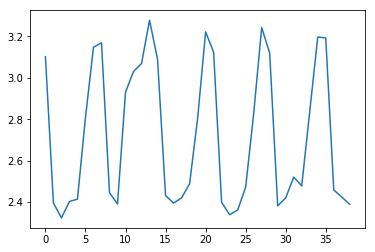

In [34]:
plt.plot(testpreds[129])

In [35]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [36]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.736635   
air_0164b9927d20bcc3_2017-04-23              1.501396   
air_0241aa3964b7f861_2017-04-23              2.323853   
air_0328696196e46f18_2017-04-23              2.070253   
air_034a3d5b40d5b1b1_2017-04-23              3.460783   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   4.678205  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   3.487951  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.214952  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   6.926831  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  30.841915

In [37]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [38]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [39]:
submission.to_csv("../submission/l2_3006_xgb_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')